# K-Nearest Neighbors

## Environment setup

In [1]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd

print(f"NumPy version: {np.__version__}")

Python version: 3.7.5
NumPy version: 1.18.1


In [2]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

In [3]:
# Import ML packages
import sklearn

print(f"scikit-learn version: {sklearn.__version__}")

from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, classification_report

scikit-learn version: 0.22.1


In [4]:
def plot_decision_boundary(pred_func, X, y, figure=None):
    """Plot a decision boundary"""

    if figure is None:  # If no figure is given, create a new one
        plt.figure()
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)

## The k-nearest neighbors algorithm

### K-NN in a nutshell

- Simple, instance-based algorithm: prediction is based on the $k$ nearest neighbors of a data sample.
- No model creation, training = storing samples.

![K-NN](images/knn.png)

### Example: planar data classification

In [5]:
# Generate 2D data
x_train, y_train = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)

rng = np.random.RandomState(2)
x_train += 2 * rng.uniform(size=x_train.shape)

print(f"x_train: {x_train.shape}. y_train: {y_train.shape}")

x_train: (100, 2). y_train: (100,)


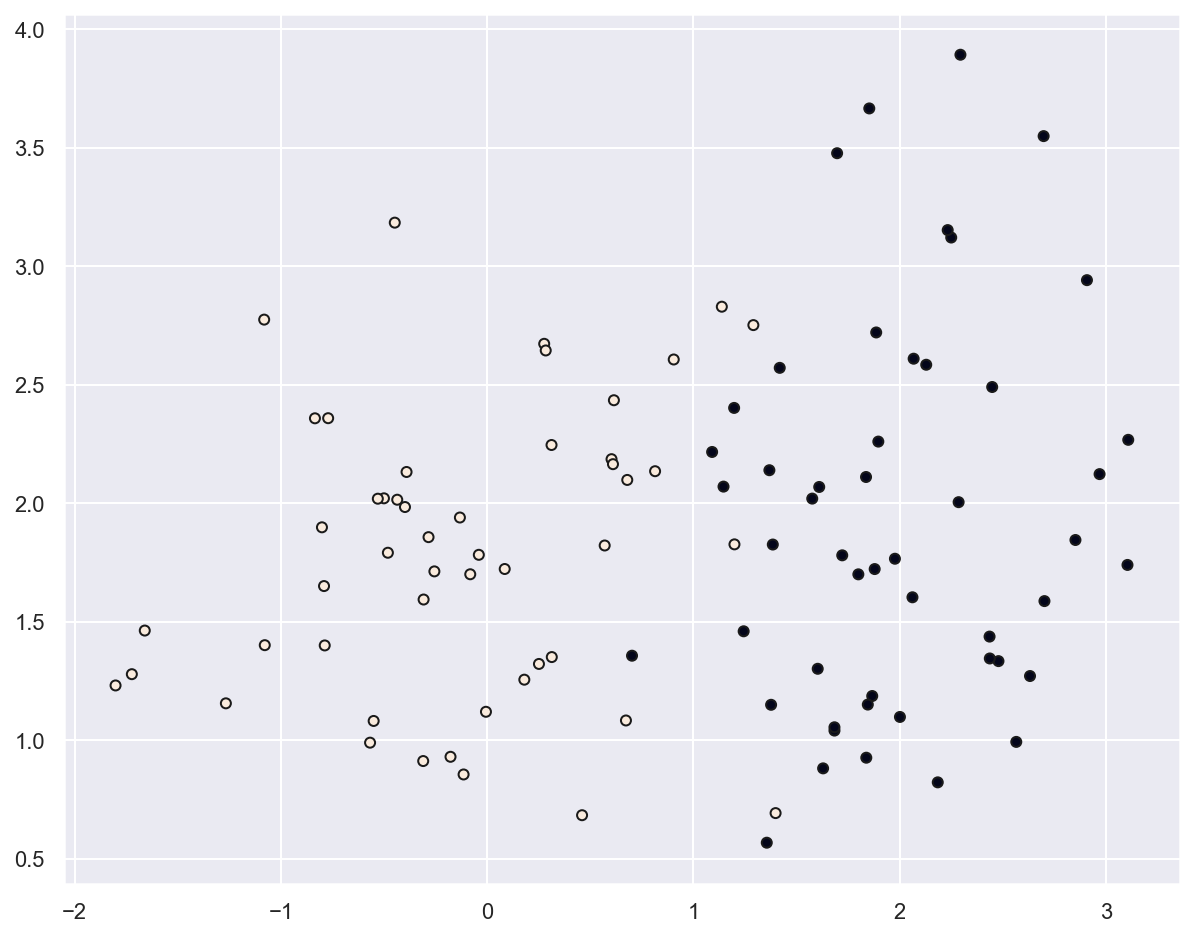

In [6]:
# Plot generated data
plt.scatter(x_train[:, 0], x_train[:, 1], marker="o", c=y_train, s=25, edgecolor="k")
plt.show()

In [7]:
# Create a K-NN classifier
knn_2d_clf = KNeighborsClassifier(n_neighbors=5)
knn_2d_clf.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

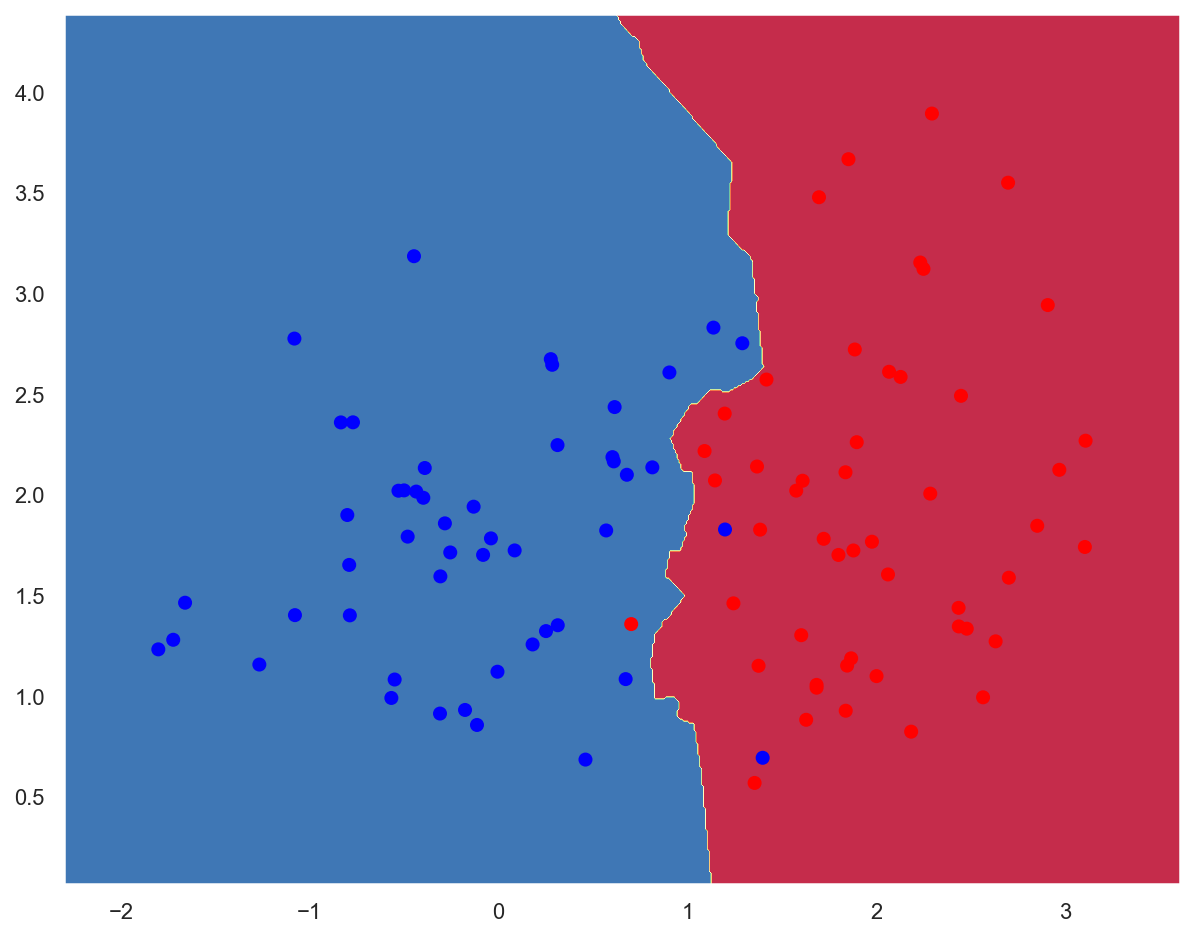

In [8]:
plot_decision_boundary(lambda x: knn_2d_clf.predict(x), x_train, y_train)

In [9]:
# Evaluate  classifier
train_acc = knn_2d_clf.score(x_train, y_train)

print(f"Training accuracy: {train_acc:.05f}")

Training accuracy: 0.97000


### Example: fruits classification

#### Data loading

In [10]:
# Download data as a text file
!wget http://www.eyrignoux.com.fr/coursIA/machineLearning/fruit_data_with_colors.txt -O fruit_data_with_colors.txt

--2022-03-22 11:32:27--  http://www.eyrignoux.com.fr/coursIA/machineLearning/fruit_data_with_colors.txt
Résolution de www.eyrignoux.com.fr (www.eyrignoux.com.fr)… 62.210.16.62
Connexion à www.eyrignoux.com.fr (www.eyrignoux.com.fr)|62.210.16.62|:80… connecté.
requête HTTP transmise, en attente de la réponse… 301 Moved Permanently
Emplacement : https://www.eyrignoux.com.fr/coursIA/machineLearning/fruit_data_with_colors.txt [suivant]
--2022-03-22 11:32:27--  https://www.eyrignoux.com.fr/coursIA/machineLearning/fruit_data_with_colors.txt
Connexion à www.eyrignoux.com.fr (www.eyrignoux.com.fr)|62.210.16.62|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 2370 (2,3K) [text/plain]
Sauvegarde en : « fruit_data_with_colors.txt »

fruit_data_with_col 100%[===================>]   2,31K  --.-KB/s    in 0s      

2022-03-22 11:32:29 (48,1 MB/s) — « fruit_data_with_colors.txt » sauvegardé [2370/2370]



In [11]:
# Load data into a DataFrame
fruits = pd.read_table("fruit_data_with_colors.txt")

# Show 10 random samples
fruits.sample(n=10)

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
25,3,orange,spanish_jumbo,356,9.2,9.2,0.75
11,1,apple,braeburn,172,7.1,7.6,0.92
56,4,lemon,unknown,116,5.9,8.1,0.73
8,1,apple,braeburn,178,7.1,7.8,0.92
14,1,apple,golden_delicious,152,7.6,7.3,0.69
21,1,apple,cripps_pink,156,7.4,7.4,0.84
35,3,orange,turkey_navel,150,7.1,7.9,0.75
58,4,lemon,unknown,118,6.1,8.1,0.70
37,3,orange,turkey_navel,154,7.3,7.3,0.79


#### Data analysis

In [12]:
# Evaluate class distribution
samples_count = fruits.size
for name in fruits["fruit_name"].unique():
    class_percent = fruits[fruits.fruit_name == name].size / samples_count
    print(f"{name}s : {class_percent * 100:.1f}%")

apples : 32.2%
mandarins : 8.5%
oranges : 32.2%
lemons : 27.1%


In [13]:
# For this scenario, we use only the mass, width, and height features of each fruit instance
x = fruits[["mass", "width", "height"]]
# Objective is to predict the fruit class
y = fruits["fruit_label"]

print(f"x: {x.shape}. y: {y.shape}")

x: (59, 3). y: (59,)


#### Data preprocessing

In [14]:
# Split data between training and test sets with a 80/20 ratio
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print(f"x_train: {x_train.shape}. y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}. y_test: {y_test.shape}")

x_train: (47, 3). y_train: (47,)
x_test: (12, 3). y_test: (12,)


In [15]:
# Standardize data
scaler = StandardScaler().fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

#### Classifier creation and "training"

In [16]:
# k = 5
knn_fruits_clf = KNeighborsClassifier(n_neighbors=5)
knn_fruits_clf.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

#### Classifier evaluation

In [17]:
# Compute accuracy on training and test sets
train_acc = knn_fruits_clf.score(x_train, y_train)
test_acc = knn_fruits_clf.score(x_test, y_test)

print(f"Training accuracy: {train_acc:.05f}")
print(f"Test accuracy: {test_acc:.05f}")

Training accuracy: 0.89362
Test accuracy: 0.75000


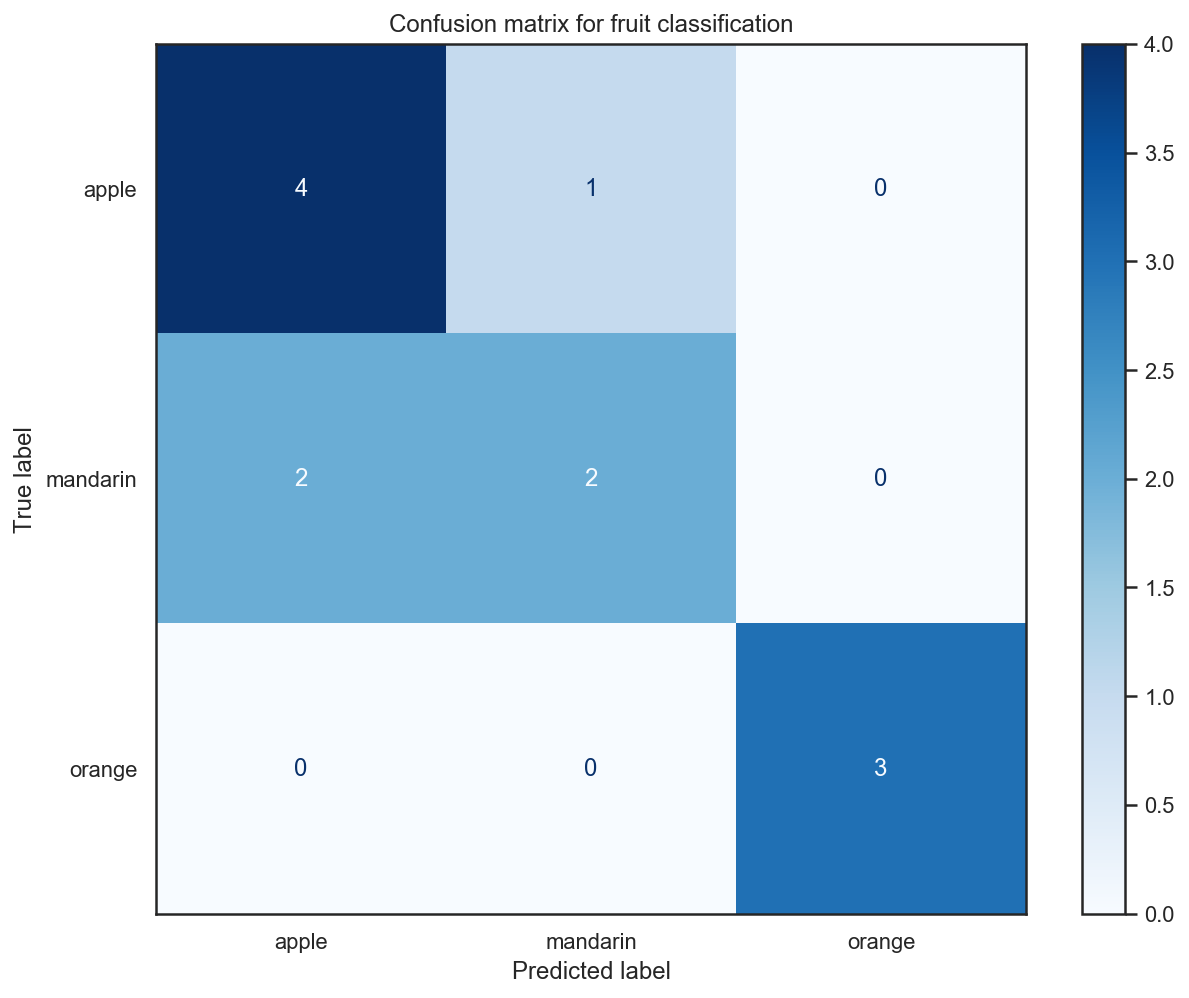

In [18]:
# Plot the confusion matrix for test data
with sns.axes_style("white"):  # Temporary hide Seaborn grid lines
    display = plot_confusion_matrix(
        knn_fruits_clf,
        x_test,
        y_test,
        display_labels=fruits["fruit_name"].unique(),
        cmap=plt.cm.Blues,
    )
    display.ax_.set_title("Confusion matrix for fruit classification")
    plt.show()

In [19]:
# Compute classification metrics
print(classification_report(y_test, knn_fruits_clf.predict(x_test)))

              precision    recall  f1-score   support

           1       0.67      0.80      0.73         5
           3       0.67      0.50      0.57         4
           4       1.00      1.00      1.00         3

    accuracy                           0.75        12
   macro avg       0.78      0.77      0.77        12
weighted avg       0.75      0.75      0.74        12



#### Using the classifier for predictions

In [20]:
# create a mapping from fruit label value to fruit name to make results easier to interpret
lookup_fruit_name = dict(zip(fruits.fruit_label.unique(), fruits.fruit_name.unique()))

In [21]:
# first example: a small fruit with mass 20g, width 4.3 cm, height 5.5 cm
fruit_prediction = knn_fruits_clf.predict([[20, 4.3, 5.5]])
lookup_fruit_name[fruit_prediction[0]]

'orange'

In [22]:
# second example: a larger, elongated fruit with mass 100g, width 6.3 cm, height 8.5 cm
fruit_prediction = knn_fruits_clf.predict([[100, 6.3, 8.5]])
lookup_fruit_name[fruit_prediction[0]]

'orange'

#### Importance of the `k` parameter

In [23]:
k_range = range(1, 20)
scores = []

# Train several classifiers with different values for k
for k in k_range:
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(x_train, y_train)
    scores.append(knn_clf.score(x_test, y_test))

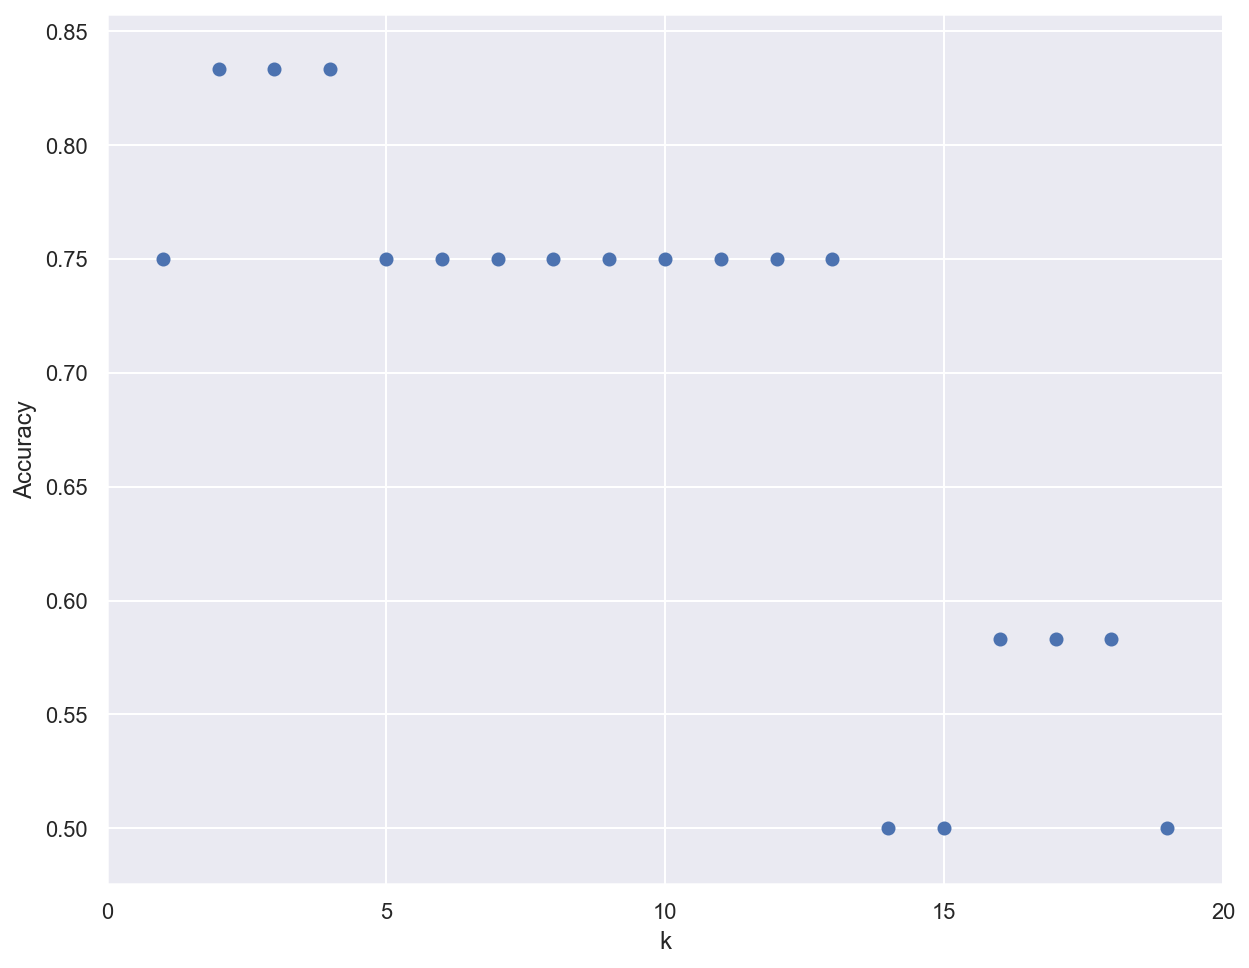

In [24]:
# Plot results
plt.figure()
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20]);

TODO

- Planar data: add multiclass data
- Better looking graphs: https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/